In [1]:

!pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 40kB/s 
     |████████████████████████████████| 4.3MB 49.8MB/s 
     |████████████████████████████████| 501kB 63.9MB/s 


In [7]:
from zipfile import ZipFile
file = "/content/Train.zip"
with ZipFile(file,'r') as zip:
    zip.extractall()
    print('Done')

Done


In [0]:
#importer les bibliothéque 
import os
import tensorflow as tf
from tensorflow.keras import models  
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

from datetime import date
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import cv2

In [0]:
base_dir_path = os.getcwd() # current directory
train_dir_path = os.path.join(base_dir_path,'Train') #path of train directory
test_dir_path = os.path.join(base_dir_path,'Test') #path of test directory
MNet_InputSize = (160,160) #size of input images

In [10]:
#Data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.4,
                             zoom_range=0.2,
                             rotation_range=50,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
        
train_generator = datagen.flow_from_directory(
            train_dir_path,  # this is the target directory
            target_size=MNet_InputSize,  # all images will be resized
            batch_size=16,
            class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
    
test_generator = datagen.flow_from_directory(
            test_dir_path,  # this is the target directory
            target_size=MNet_InputSize,  # all images will be resized
            batch_size=16,
            class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 7139 images belonging to 6 classes.
Found 3350 images belonging to 6 classes.


In [0]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               pooling='avg',
                                               weights='imagenet')

In [0]:
#Unfreeze the convolutional base
base_model.trainable = True

In [0]:
#create the classifier model 
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(6,activation='sigmoid'))

#compile the model
optimizer = Adam(lr=1e-5, decay=1e-6)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
# take a look at the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 1280)              2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 3078      
Total params: 2,918,982
Trainable params: 2,883,846
Non-trainable params: 35,136
_______________________________________

In [0]:
def SaveModelFile(ClassifyModel,save_model_filename):
    """
    Saves trained classification model
    
    Args:
        ClassifyModel : trained classification Model
        save_model_filename(str): filename, to save trained model,without extension.
        
    Returns:
        save_model_filename(str): filename with extension.
    """
    today = date.today()
    date_str = today.strftime("%d%m%y")
    save_model_filename = '_'.join([save_model_filename,date_str])
    save_model_filename = save_model_filename +'.h5'
    ClassifyModel.save(save_model_filename)
    print('Done Saving Model File...')
    return save_model_filename

In [30]:
#Train the model
history = model.fit_generator(train_generator,
                              epochs=20,
                              validation_data = test_generator,
                              verbose=1)
#Save the model
trainedModel_Filename = SaveModelFile(model,'multiLabel_model_true')

Epoch 1/20
447/447 [==============================] - 152s 340ms/step - loss: 0.7952 - accuracy: 0.6176 - val_loss: 0.6942 - val_accuracy: 0.6623
Epoch 2/20
447/447 [==============================] - 151s 337ms/step - loss: 0.5965 - accuracy: 0.7184 - val_loss: 0.6041 - val_accuracy: 0.7266
Epoch 3/20
447/447 [==============================] - 151s 338ms/step - loss: 0.4968 - accuracy: 0.7713 - val_loss: 0.5337 - val_accuracy: 0.7770
Epoch 4/20
447/447 [==============================] - 151s 338ms/step - loss: 0.4160 - accuracy: 0.8155 - val_loss: 0.3844 - val_accuracy: 0.8495
Epoch 5/20
447/447 [==============================] - 150s 335ms/step - loss: 0.3614 - accuracy: 0.8453 - val_loss: 0.3202 - val_accuracy: 0.8868
Epoch 6/20
447/447 [==============================] - 150s 336ms/step - loss: 0.3232 - accuracy: 0.8664 - val_loss: 0.2770 - val_accuracy: 0.9092
Epoch 7/20
447/447 [==============================] - 149s 334ms/step - loss: 0.2781 - accuracy: 0.8875 - val_loss: 0.2515 -

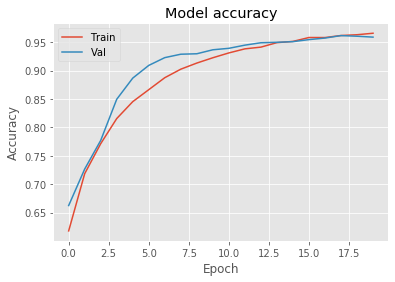

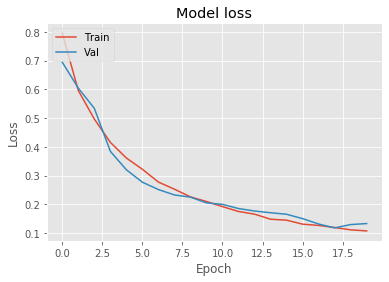

In [34]:
# Plot training & validation accuracy values
mpl.use("Agg")
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('Accuracy.png')

# Plot training & validation loss values
plt.style.use("ggplot")
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('Loss.png')